
# **Assignment 3** (116 pts total)
---
---
## **Instructions**
* This is an individual assignment. You are **not allowed** to discuss the problems with other students.
* Part of this assignment will be autograded by gradescope. You can use it as immediate feedback to improve your answers. You can resubmit as many times as you want.
* All your solution, code, analysis, graphs, explanations should be done in this same notebook.
* Please make sure to execute all the cells before you submit the notebook to the gradescope. You will not get points for the plots if they are not generated already.
* Please **do not** change the random seeds
* If you have questions regarding the assignment, you can ask for clarifications on Piazza. You should use the corresponding tag for this assignment.
* The deadline for submitting this assignment is **10:00 PM on Sunday,** **November 5, 2023**
---
---
This assignment has four parts. Part 1 will focus on the Monte Carlo method, you will learn:

1. To use the Monte Carlo method for control


Part 2 will focus on *prediction*. You will learn:

1. To use Monte Carlo estimates for prediction
2. To use Temporal difference methods for prediction
3. To understand the relationship between the two, and unifying the algorithms

Part 3 will focus on Temporal Difference control methods. You will learn:

1. To use SARSA for optimal control
2. To use Q-learning for optimal control

Part 4 will focus on Deep Q-learning. You will learn:

1. To use and evaluate DQN for environments with continuous state spaces

In [1]:
## INSTALL DEPENDENCIES
!pip install gymnasium
!pip install torch
!pip install matplotlib
!pip install tqdm

In [2]:
!pip install otter-grader
!git clone https://github.com/chandar-lab/INF8250ae-assignments-2023 public

fatal: destination path 'public' already exists and is not an empty directory.


In [3]:
## Initialize Otter
import otter
grader = otter.Notebook(colab=True, tests_dir='./public/a3/tests')

In [4]:
import matplotlib.pyplot as plt

import random
import numpy as np

# Set seed
seed = 10
np.random.seed(seed)
random.seed(seed)
import warnings
warnings.filterwarnings('ignore')

# Environment



Consider environment ```FloorIsLava```, a Grid World variant of the ```FrozenLake-v0``` environment (https://gymnasium.farama.org/environments/toy_text/frozen_lake/) from the OpenAI gym library. Assume that the agent here is navigating on a different planet, called **Planet558**, and the surface consists of mostly safe paths but with molten lava in certain tiles of the grid. The goal of the agent is to find the shortest path to safely reach the goal tile ```G``` from the start tile ```S``` on a ```6x6``` grid (or in general, any size). The safe walkable tiles are indicated by ```P``` and the lava tiles are indicated by ```L```. Going to the lava tile leads to the agent's destruction and termination of the episode.  
Additionally, there is another tile ```T``` that magically teleports the agent to a new tile ```Z```.  The states are denoted by: $S=\{0,1,2,...,34, 35\}$ for a ```6x6``` grid.


The agent can move in the four cardinal directions, $A=\{left, down, right, up\}$, but the surface is slippery! Given a `slip_rate` of $0 \leq \xi < 1$, the agent will go in a random wrong direction with probability $\xi$.


The reward is $-1$ on all transitions, except for three cases that all result in the episode terminating: (1) The agent falling into a lava gets the agent a reward of $-100$, (2) The agent takes over 50 steps, after which the whole surface gets dissolved in lava and the agent gets a reward of $-100$, and (3) The agent reaches the goal state with a reward of $0$. The discount factor for this environment should be set to $\gamma = 0.99$. The environment is implemented for you below.

Example 6x6 `FloorIsLava` environment

|            |            |            |            |            |            |            
|------------|------------|------------|------------|------------|------------|
| `S`   | `P` |`P` | `P` | `T` |`P`   |
| `P` | `P` | `P` | `L` | `P` |`S`   |
| `P` | `P` |`P` | `P` | `P` |`P`   |
| `P` | `L` |`P` | `P` | `L` |`P`   |
| `P` | `P` |`Z` | `P` | `L` |`P`   |
| `P` | `P` |`P` | `P` | `G` |`P`   |






In [5]:
import sys
from contextlib import closing
from tqdm import tqdm
import torch
import copy
import numpy as np
from io import StringIO
import gymnasium as gym
from gymnasium import utils
from gymnasium import Env, spaces
from gymnasium.utils import seeding

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

MAPS = {
    "2x2": ["SP", "PG"],
    "4x4-easy":["SPPP", "PLPP", "PPLL", "LPPG"],
    "4x4": ["SPPT", "PLPL", "PPLZ", "LPPG"],
    "6x6": [
        "SPPTPL",
        "PPPLPP",
        "PPPPPP",
        "PLPPLP",
        "PPZPLP",
        "PPLPGP",
    ],
}



def categorical_sample(prob_n, np_random):
    """
    Sample from categorical distribution
    Each row specifies class probabilities
    """
    prob_n = np.asarray(prob_n)
    csprob_n = np.cumsum(prob_n)
    return (csprob_n > np_random.random()).argmax()


class DiscreteEnv(Env):

    """
    Has the following members
    - nS: number of states
    - nA: number of actions
    - P: transitions (*)
    - isd: initial state distribution (**)
    (*) dictionary of lists, where
      P[s][a] == [(probability, nextstate, reward, done), ...]
    (**) list or array of length nS
    """

    def __init__(self, nS, nA, P, isd, max_length=50):
        self.P = P
        self.isd = isd
        self.lastaction = None  # for rendering
        self.nS = nS
        self.nA = nA

        self.action_space = spaces.Discrete(self.nA)
        self.observation_space = spaces.Discrete(self.nS)

        self.seed()
        self.s = categorical_sample(self.isd, self.np_random)
        self.max_length = max_length

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        self.s = categorical_sample(self.isd, self.np_random)
        self.lastaction = None
        self.t = 0
        info = {}
        return int(self.s), info

    def step(self, a):
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        p, s, r, d = transitions[i]
        self.s = s
        self.lastaction = a
        trunc = False
        if self.t >= self.max_length:
            d = True
            r = -100
        self.t += 1
        return (int(s), r, trunc, d, {"prob": p})

class FloorIsLava(DiscreteEnv):
    """
    You are building small rovers to explore Planet558 and search for rare minerals.
    Assume you have an accurate simulation model of the actual environment in
    Planet558 (including the presence of lava regions at a particular instant),
    and locations of mineral sites where the rovers have to
    reach and send signals back to Earth regarding the chemical composition. You
    are required to load one of the rovers with a trained policy corresponding
    to the specific Grid World problem that it has to encounter, where the policy
    is obtained by training with a simulation model environment. Note the slippery
    nature of the surface, which poses further problems for the rover.
    The surface is described using a grid like the following
        SPPT
        PLPL
        PPPL
        LZPG
    S : starting point, safe
    P : safe path tile
    L : lava, the rover falls to its doom
    T : teleport, a magical phenomenon that teleports the rover to a different tile
    Z : teleport destination, the rover teleports to this location when it encounters T
    G : goal, where the mineral site is located
    The episode ends when you reach the goal or fall in the lava.
    """

    metadata = {"render.modes": ["human", "ansi"]}

    def __init__(self, desc=None, map_name="4x4", slip_rate=0.5):
        if map_name not in MAPS:
            raise ValueError(f"Invalid map: {map_name}")
        desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc, dtype="c")
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)

        nA = 4
        nS = nrow * ncol

        isd = np.array(desc == b"S").astype("float64").ravel()
        isd /= isd.sum()
        tele_in = np.where(np.array(desc == b"T").astype("float64").ravel())[0] # teleportation state
        tele_out = np.where(np.array(desc == b"Z").astype("float64").ravel())[0] # teleport destination state
        P = {s: {a: [] for a in range(nA)} for s in range(nS)}

        def to_s(row, col):
            return row * ncol + col

        def inc(row, col, a):
            if a == LEFT:
                col = max(col - 1, 0)
            elif a == DOWN:
                row = min(row + 1, nrow - 1)
            elif a == RIGHT:
                col = min(col + 1, ncol - 1)
            elif a == UP:
                row = max(row - 1, 0)
            return (row, col)

        def update_probability_matrix(row, col, action):
            newrow, newcol = inc(row, col, action)
            newstate = to_s(newrow, newcol)
            newletter = desc[newrow, newcol]
            done = bytes(newletter) in b"GH"
            # reward = float(newletter == b"G")
            reward = -1
            # if newletter == b"H":
            #     reward = -100
            done = False
            return newstate, reward, done

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = P[s][a]
                    letter = desc[row, col]
                    if letter == b"G":
                        li.append((1.0, s, 0, True))
                    elif letter == b'L':
                        li.append((1.0, s, -100, True))
                    elif letter == b'T':
                        if s == tele_in[0]:
                            li.append((1.0, tele_out[0], -1, False))
                    else:
                        if slip_rate > 0:
                            li.append((1 - slip_rate, *update_probability_matrix(row, col, a)))
                            li.append((slip_rate/3.0, *update_probability_matrix(row, col, (a - 1) % 4)))
                            li.append((slip_rate/3.0, *update_probability_matrix(row, col, (a + 1) % 4)))
                            li.append((slip_rate/3.0, *update_probability_matrix(row, col, (a + 2) % 4)))
                        else:
                            li.append((1.0, *update_probability_matrix(row, col, a)))

        super(FloorIsLava, self).__init__(nS, nA, P, isd)

    def render(self, mode="human"):
        outfile = StringIO() if mode == "ansi" else sys.stdout

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = self.desc.tolist()
        desc = [[c.decode("utf-8") for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write(
                "  ({})\n".format(["Left", "Down", "Right", "Up"][self.lastaction])
            )
        else:
            outfile.write("\n")
        outfile.write("\n".join("".join(line) for line in desc) + "\n")

        if mode != "human":
            with closing(outfile):
                return outfile.getvalue()

# Part 0 - Helper Methods (5pts)
First, let us define some helper methods that will be useful for the entire assignment. We give here three methods that you may use or not use at any point of the assignment

In [6]:
def random_policy(state):
    """
    Input: state (int) [0, .., 35]
    output: action (int) [0,1,2,3]
    """
    return np.random.randint(0,4)

def plot_many(experiments, label=None, color=None):
    mean_exp = np.mean(experiments, axis=0)
    std_exp = np.std(experiments, axis=0)
    plt.plot(mean_exp, color=color, label=label)
    plt.fill_between(range(len(experiments[0])), mean_exp + std_exp, mean_exp - std_exp, color=color, alpha=0.1)

def random_argmax(value_list):
    """ a random tie-breaking argmax """
    values = np.asarray(value_list)
    return np.argmax(np.random.random(values.shape) * (values==values.max()))

## Question 0.1 - Creating some helper methods (5pts)



### Question 0.1a (2 pts)
Implement an epsilon-greedy policy over the state-action values of an environment.

**Note: Please make use of the `random_argmax` function for only this part, and NOT Part 4.**

In [7]:
def make_eps_greedy_policy(state_action_values, epsilon):
    """
    Implementation of epsilon-greedy policy
    Note: Please make use of the helper functions (random_policy, random_argmax)
    defined in the previous cell. Also, please use Numpy's function for the random number generator.
    Input:
        state_action_values (list[list]): first axis maps over states of an environment, and second axis the actions.
                                        The stored values are the state-action values corresponding to the state and action index
        epsilon (float): Probability of taking a random action
    Returns policy (int -> int): method taking a state and returning a sampled action to take
    """
    def policy(state):
        # TO IMPLEMENT
        # --------------------------------
        random_value = np.random.default_rng().uniform()
        if random_value < epsilon:
            return random_policy(state)
        return random_argmax(state_action_values[state])
        # --------------------------------
    return policy

In [8]:
grader.check("question 0.1a")

question 0.1a results: All test cases passed!

### Question 0.1b (3 pts)
**b)** Create a function `generate_episode` which takes as input a policy $\pi$ (like the one outputted by **question 1a**), the environment, and the boolean `render` which renders every step of the episode in text form (rendering the episode is as easy as calling `env.render()`). The output of this function should return the tuple $\texttt{states}, \texttt{actions}, \texttt{rewards}$ containing the states, actions, and rewards of the generated episode following $\pi$.

In [9]:
def generate_episode(policy:callable, env:gym.Env, render=False):
    """
    Input:
        policy (int -> int): policy taking a state as an input and outputs a given action
        env (DiscreteEnv): The FloorIsLava environment
        render (bool): Whether or not to render the episode
    Returns:
        states (list): the sequence of states in the generated episode
        actions (list): the sequence of actions in the generated episode
        rewards (list): the sequence of rewards in the generated episode
    """
    # --------------------------------
    states = []
    rewards = []
    actions = []
    terminated = False
    truncated = False
    obs, info = env.reset()
    states.append(obs)
    if render:
        env.render()

    while not terminated and not truncated:
        action = policy(obs)
        actions.append(action)
        obs, reward, terminated, truncated, info = env.step(action)
        states.append(obs)
        if render:
            env.render()
        rewards.append(reward)
    # --------------------------------
    return states, actions, rewards

In [10]:
grader.check("question 0.1b")

question 0.1b results: All test cases passed!

# Part 1 - Monte Carlo Methods (15 pts)

Consider in this section the 6x6 version of the `FloorIsLava` environment, with a `slip_rate` of 0.1. Again, make sure to use a discount factor of $\gamma=0.99$ for all your experiments. This environment can be instantiated with `env = FloorIsLava(map_name="6x6", slip_rate=0.1)`

## Question 1.1 (15 pts)


### Question 1.1a (5pts)
Implement the first-visit Monte Carlo (for $\epsilon$-soft policies) control algorithm to find the approximate optimal policy $\pi \approx \pi_*$.

In [11]:
def fv_mc_estimation(states, actions, rewards, discount):
    """
    Input:
        states (list): states of an episode generated from generate_episode
        actions (list): actions of an episode generated from generate_episode
        rewards (list): rewards of an episode generated from generate_episode
        discount (float): discount factor
    Returns visited_states_returns (dictionary):
        keys are all the unique state-action combinations in the episode
        values are the estimated discounted return of the first visited pair
    """
    visited_states_returns = {}
    # TO IMPLEMENT
    # --------------------------------
    G = 0
    for t in range(len(states)-2, -1, -1):
        G = discount * G + rewards[t]
        if (states[t], actions[t]) not in visited_states_returns:
            visited_states_returns[(states[t], actions[t])] = G
    # --------------------------------
    return visited_states_returns

In [12]:
grader.check("question 1.1a")

question 1.1a results: All test cases passed!

Given your implementation of `fv_mc_estimation`, we can now do control.

In [13]:
def fv_mc_control(env, epsilon=0.05, num_episodes=100, discount=0.99):
    # Initialize memory of estimated state-action returns
    state_action_returns = [[[] for j in range(env.action_space.n)] for i in range(env.observation_space.n)]
    all_returns = []

    for j in range(num_episodes):
        state_action_values = [[np.mean(a) for a in s] for s in state_action_returns]
        policy = make_eps_greedy_policy(state_action_values, epsilon)
        states, actions, rewards = generate_episode(policy, env)
        visited_states_returns = fv_mc_estimation(states, actions, rewards, discount)
        for sa in visited_states_returns:
            s, a = sa
            state_action_returns[s][a].append(visited_states_returns[sa])
        all_returns.append(np.sum(rewards))

    state_action_values = [[np.mean(a) for a in s] for s in state_action_returns]
    return state_action_values, all_returns

<!-- BEGIN QUESTION -->

### Question 1.1b - Plotting (3pts)

Let $\epsilon=0.05$, run the algorithm for 2000 episodes, and repeat this experiment for 5 different runs. Plot the average undiscounted return across the 5 different runs with respect to the number of episodes (x-axis is the 2000 episodes, y-axis is the return for each episode)

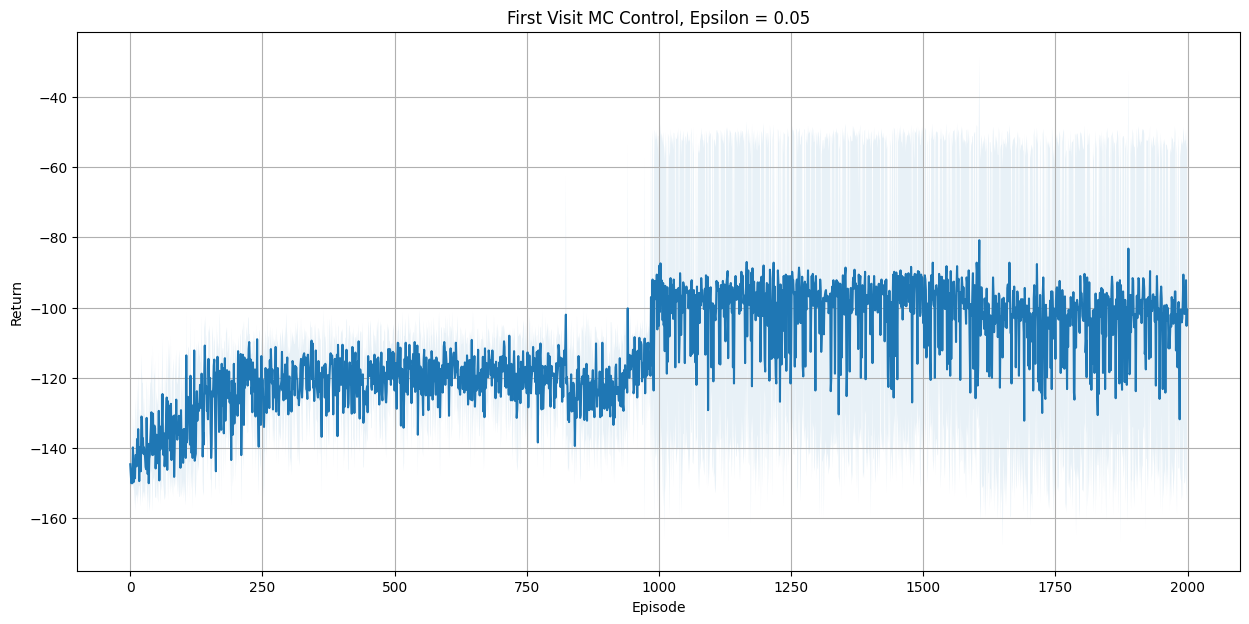

In [14]:
env = FloorIsLava(map_name="6x6", slip_rate=0.1)

# Set seed
seed = 10
env.seed(seed)
np.random.seed(seed)
random.seed(seed)

all_sa_values, all_returns = [], []
for t in range(5):
    sa_values, returns = fv_mc_control(env, epsilon=0.05, num_episodes=2000)
    all_sa_values.append(sa_values)
    all_returns.append(returns)

plt.figure(figsize=(15,7))
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('First Visit MC Control, Epsilon = 0.05')
plt.grid()
plot_many(all_returns)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1.1c (2 pts)
Visualize an episode during evaluation with the last learned state-action value tables using the code below. For clarity, let's evaluate an episode with `0 slip_rate` and $\epsilon=0$. In the absence of a slip-rate and exploration, what is the return of the optimal policy for all 5 learned state-action value tables?

In [15]:
# Visualize path
env = FloorIsLava(map_name="6x6", slip_rate=0.)
optimal_policy = make_eps_greedy_policy(all_sa_values[-1], epsilon=0.)

s, a, r = generate_episode(optimal_policy, env, render=True)


SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Right)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Right)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Right)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Down)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Right)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Down)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Right)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Up)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP


In [16]:
# Getting the return during evaluation
env = FloorIsLava(map_name="6x6", slip_rate=0.)
for t in range(5):
    optimal_policy = make_eps_greedy_policy(all_sa_values[t], epsilon=0.)
    s, a, r = generate_episode(optimal_policy, env, render=False)
    print('Return is ' + str(np.sum(r)))

Return is -111
Return is -130
Return is -110
Return is -150
Return is -7


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1.1d - Plotting again (2pts)
##### Now repeat the exercise from b), but set $\epsilon=0.5$.

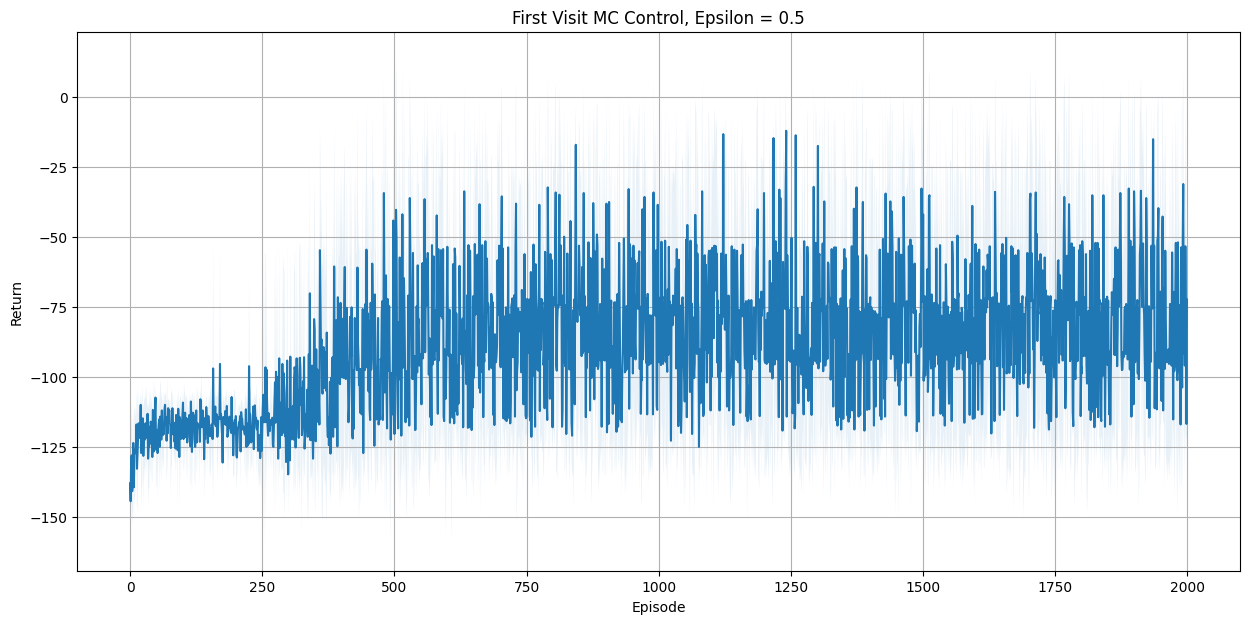

In [17]:
env = FloorIsLava(map_name="6x6", slip_rate=0.1)

# Set seed
env.seed(seed)
np.random.seed(seed)
random.seed(seed)

all_sa_values_c, all_returns_c = [], []
for t in range(5):
    sa_values, returns = fv_mc_control(env, epsilon=0.5, num_episodes=2000)
    all_sa_values_c.append(sa_values)
    all_returns_c.append(returns)

plt.figure(figsize=(15,7))
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('First Visit MC Control, Epsilon = 0.5')
plt.grid()
plot_many(all_returns_c)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->



In [18]:
# Visualize path taken
env = FloorIsLava(map_name="6x6", slip_rate=0.)
optimal_policy = make_eps_greedy_policy(all_sa_values_c[-1], epsilon=0.)
s, a, r = generate_episode(optimal_policy, env, render=True)


SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Down)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Down)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Right)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Right)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Down)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Down)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Right)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Down)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Right)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Left)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP


In [19]:
# Get evaluation return
for t in range(5):
    env = FloorIsLava(map_name="6x6", slip_rate=0.)
    optimal_policy = make_eps_greedy_policy(all_sa_values_c[t], epsilon=0.)
    s, a, r = generate_episode(optimal_policy, env, render=False)
    print('Return is ' + str(np.sum(r)))

Return is -150
Return is -150
Return is -7
Return is -9
Return is -9


<!-- END QUESTION -->

### Question 1.1e  (3pts)
 Based on the returns obtained from policies from the learned sate-action value tables, compare the learning performances with $\epsilon=0$ and $\epsilon=0.5$. In which case the agent learns better, i.e. does higher exploration encourage better policies? What do you notice while visualizing the suboptimal policies? Briefly explain why in 1 to 3 sentences.  

# Part 2 -  Prediction: Unifying Monte Carlo methods and Temporal Difference Learning (46 pts)

Consider in this section the same 6x6 `FloorIsLava` environment with a `slip_rate` of 0.1. Use a discount factor of $\gamma=0.99$. We will be working with the same random policy used above for all questions in this part: $\pi(a|s) = 0.25$ for all $a$ and $s$.

## Question 2.1 - MC (10 pts)


### Question 2.1a (5 pts)
Implement the *Every visit Monte Carlo prediction* algorithm in order to estimate $V^\pi(s)$.

In [20]:
def ev_mc_estimate(states, actions, rewards, discount):
    """
    Input:
        states (list): states of an episode generated from generate_episode
        actions (list): actions of an episode generated from generate_episode
        rewards (list): rewards of an episode generated from generate_episode
        discount (float): discount factor
    Returns visited_states_returns (dictionary):
        Keys are all the states visited in an the given episode
        Values is a list of the estimated MC return of a given state.
            i.e: if a state is visited 3 times in an episode, there are 3 estimated returns of that state.
    """
    visited_state_returns = {}
    # TO IMPLEMENT
    # --------------------------------
    G = 0
    for t in range(len(states)-2, -1, -1):
        G = discount * G + rewards[t]
        if states[t] not in visited_state_returns:
            visited_state_returns[states[t]] = [G]
        else:
            visited_state_returns[states[t]].append(G)
    # --------------------------------
    return visited_state_returns

In [21]:
grader.check("question 2.1a")

question 2.1a results: All test cases passed!

We now use `ev_mc_estimate` to do prediction

In [22]:
def ev_mc_pred(policy, env, num_episodes=100, discount=0.99):
    state_returns = [[0] for i in range(env.observation_space.n)]
    state_values_trace = []
    for j in (range(num_episodes)):
        states, actions, rewards = generate_episode(policy, env)
        visited_state_returns = ev_mc_estimate(states, actions, rewards, discount)
        for s in visited_state_returns:
            state_returns[s].extend(visited_state_returns[s])
        state_values_trace.append([np.mean(s) for s in state_returns])
    return state_values_trace

<!-- BEGIN QUESTION -->

### Question 2.1b - Plotting (5 pts)
 Train the algorithm for 10000 episodes, and plot the learning curves for each $s$ of $V^\pi(s)$ over the number of episodes. The result should be 1 figure, with 36 curves plotted inside it (one for each state, x-axis is the 10000 episodes, y-axis is the current estimate of $V^\pi(s)$)

In [23]:
env = FloorIsLava(map_name="6x6", slip_rate=0.1)
# Set seed
seed = 10
env.seed(seed)
np.random.seed(seed)
random.seed(seed)
ev_state_vals = ev_mc_pred(random_policy, env, num_episodes=10000, discount=0.99)

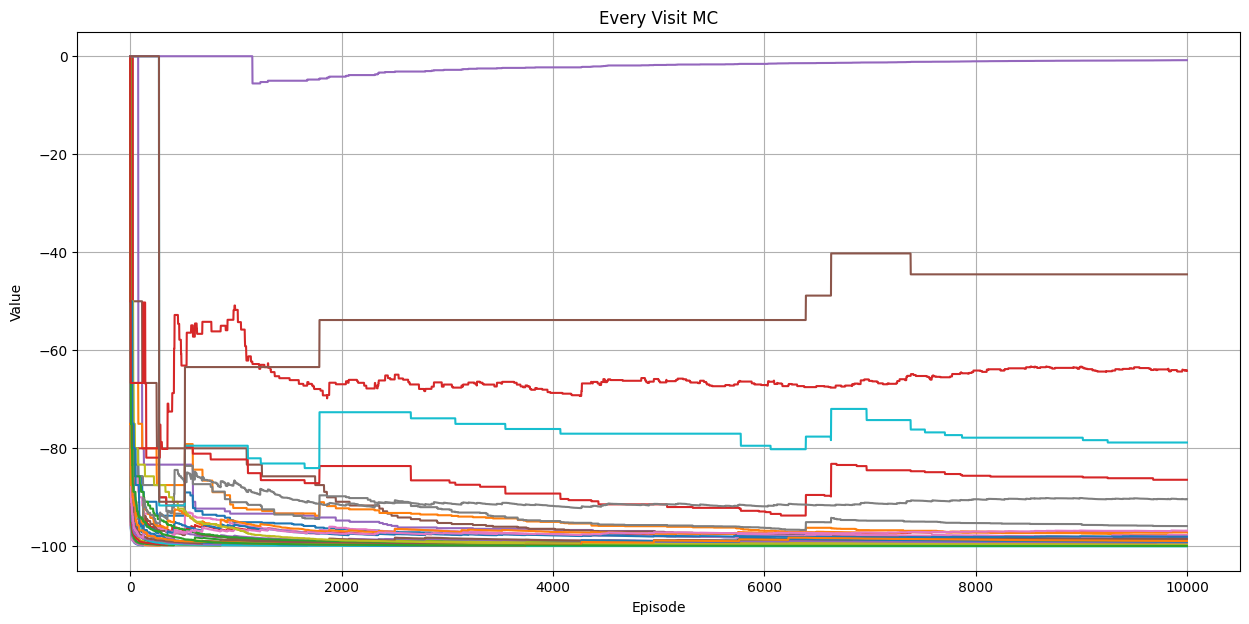

In [24]:
plt.figure(figsize=(15,7))
plt.xlabel('Episode')
plt.ylabel('Value')
plt.title('Every Visit MC')
plt.grid()
plt.plot(ev_state_vals)

<!-- END QUESTION -->

## Question 2.2 - TD(0) (10 pts)

### Question 2.2a (5 pts)
Implement the `TD(0)` prediction algorithm to estimate $V^\pi(s)$.

In [25]:
def td0(policy, env, step_size=0.1, num_episodes=100, discount=0.99):
    """
    Input:
        policy (int -> int): policy to evaluate
        env (DiscreteEnv): FloorIsLava environment
        step_size (float): step size alpha of td learning
        num_episodes (int): number of episodes to run the algorithm for
        discount (float): discount factor
    Returns state_values_trace (list of lists):
        Value estimates of each state at every episode of training.

    Do not modify state_values_trace. JUST UPDATE state_values.
        state_values keep tracks of the value of each state. Each index of state_values represents one state.
    """
    state_values = [0 for i in range(env.observation_space.n)]
    state_values_trace = []
    for j in (range(num_episodes)):
        # TO IMPLEMENT
        # --------------------------------
        done = False
        obs, info = env.reset()
        while not done:
            action = policy(obs)
            new_obs, reward, _, done, info = env.step(action)
            if done:
                state_values[obs] = state_values[obs] + step_size * (reward - state_values[obs])
                break
            state_values[obs] = state_values[obs] + step_size * (reward + discount * state_values[new_obs] - state_values[obs])
            obs = new_obs
        # --------------------------------
        state_values_trace.append([s for s in state_values])
    return state_values_trace

In [26]:
grader.check("question 2.2a")

question 2.2a results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 2.2b - Plotting (5 pts)
Use a step size $\alpha=0.01$. Train the algorithm for 10000 episodes as well, and plot the same figure as in the previous question ($V^\pi(s)$ for each $s$ over the number of episodes).

In [27]:
env = FloorIsLava(map_name="6x6", slip_rate=0.1)
# Set seed
seed = 10
env.seed(seed)
np.random.seed(seed)
random.seed(seed)
td_state_vals = td0(random_policy, env, step_size=0.01, num_episodes=10000)

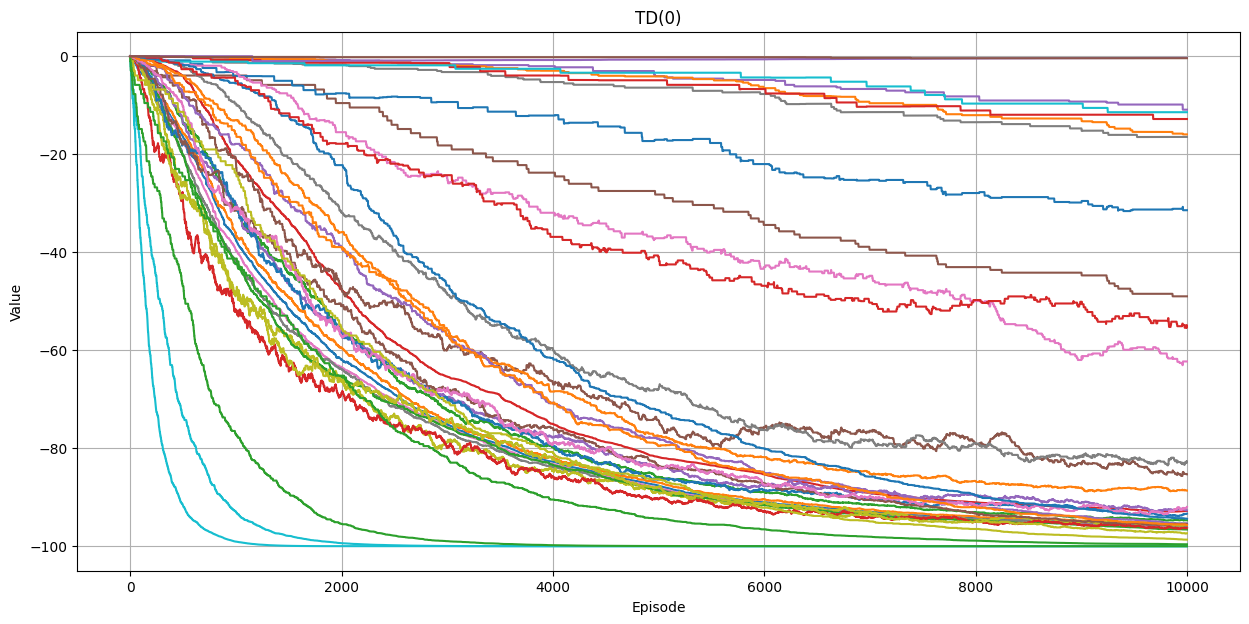

In [28]:
plt.figure(figsize=(15,7))
plt.plot(td_state_vals)
plt.xlabel('Episode')
plt.ylabel('Value')
plt.title('TD(0)')
plt.grid()

<!-- END QUESTION -->

## Question 2.3 - TDN (12 pts)

### Question 2.3a (5pts)

Now, implement the *n-step* `TD` algorithm to estimate $V^\pi(s)$.

In [29]:
def tdn(policy, env, n, step_size=0.1, num_episodes=100, discount=0.99):
    """
    Input:
        policy (int -> int): policy to evaluate
        env (DiscreteEnv): FloorIsLava environment
        n (int): Number of steps before bootstrapping for td(n) algorithm
        step_size (float): step size alpha of td learning
        num_episodes (int): number of episodes to run the algorithm for
        discount (float): discount factor
    Returns state_values_trace (list of lists):
        Value estimates of each state at every episode of training.

    Do not modify state_values_trace. JUST UPDATE state_values.
        state_values keep tracks of the value of each state. Each index of state_values represents one state.
    """
    state_values = [0 for i in range(env.observation_space.n)]
    state_values_trace = []
    for j in (range(num_episodes)):
        # TO IMPLEMENT
        # --------------------------------
        obs, info = env.reset()
        T = float('inf')
        t = 0
        episode_rewards = []
        episode_states = [obs]
        episode_actions = []
        while True:
            if t < T:
                action = policy(obs)
                obs, reward, _, done, info = env.step(action)
                episode_actions.append(action)
                episode_states.append(obs)
                episode_rewards.append(reward)
                if done:
                    T = t + 1
            tau = t - n
            if tau >= 0:
                G = sum(discount**(i-tau) * episode_rewards[i] for i in range(tau, min(tau+n+1, T)))
                if tau + n+1 < T:
                    G = G + discount**(n+1) * state_values[episode_states[tau+n+1]]
                state_values[episode_states[tau]] = state_values[episode_states[tau]] + step_size * (G - state_values[episode_states[tau]])
            if tau == T - 1:
                break
            t = t + 1
        # --------------------------------
        state_values_trace.append([s for s in state_values])
    return state_values_trace

In [30]:
grader.check("question 2.3a")

question 2.3a results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 2.3b - Plotting (2 pts)
Use a step size of $\alpha=0.01$. This algorithm should take the additional hyper-parameter $n$ to determine how much to bootstrap. Now set $n=0$, and train the algorithm for 10000 episodes. Plot the the same figure as before ($V^\pi(s)$ for each $s$ over the number of episodes)

In [31]:
env = FloorIsLava(map_name="6x6", slip_rate=0.1)
# Set seed
seed = 10
env.seed(seed)
np.random.seed(seed)
random.seed(seed)
tdn1_state_vals = tdn(random_policy, env, n=0, step_size=0.01, num_episodes=10000)

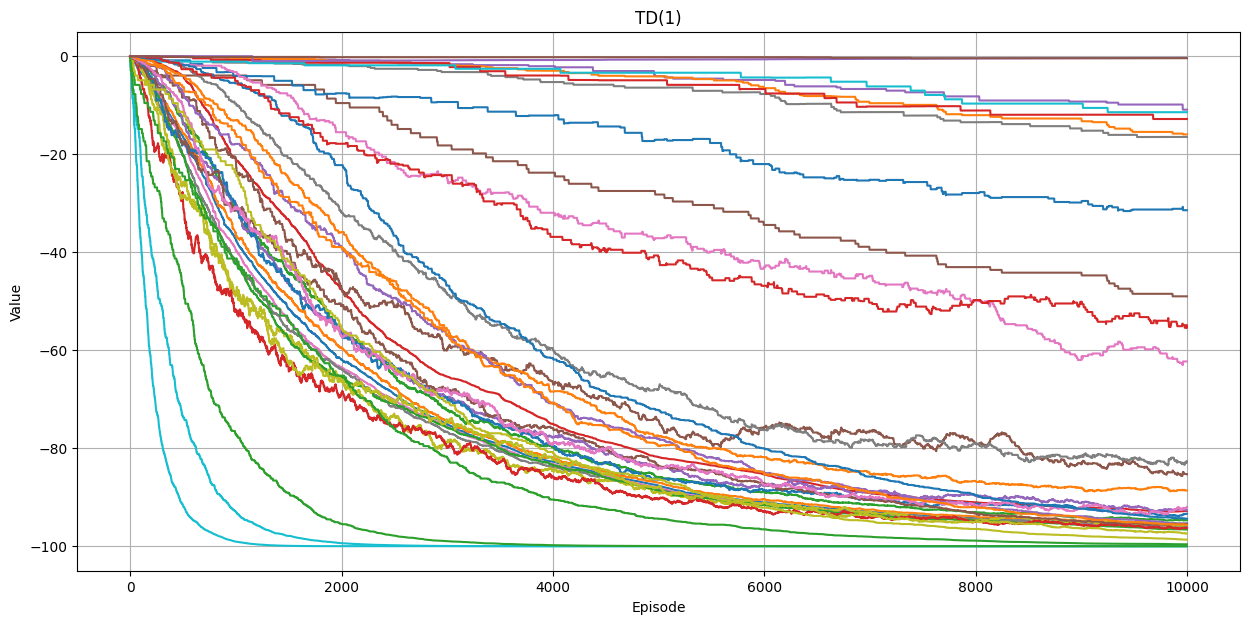

In [32]:
plt.figure(figsize=(15,7))
plt.plot(tdn1_state_vals)
plt.xlabel('Episode')
plt.ylabel('Value')
plt.title('TD(1)')
plt.grid()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2.3c (3 pts)
Compare this figure to `TD(0)` and *Every visit Monte Carlo Prediction*. Which algorithm do you expect this figure to look similar to? Does it, why or why not?

ANSWER HERE

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2.3d - Plotting (2 pts)
Using the same implementation of *n-step* `TD`, estimate $V^\pi(s)$ using $n = 100$ instead (still with $\alpha=0.01$ and 10000 episodes). Again, plot the same figure as before ($V^\pi(s)$ for each $s$ over the number of episodes).

In [33]:
env = FloorIsLava(map_name="6x6", slip_rate=0.1)
# Set seed
seed = 10
env.seed(seed)
np.random.seed(seed)
random.seed(seed)
tdn100_state_vals = tdn(random_policy, env, n=100, step_size=0.01, num_episodes=10000)

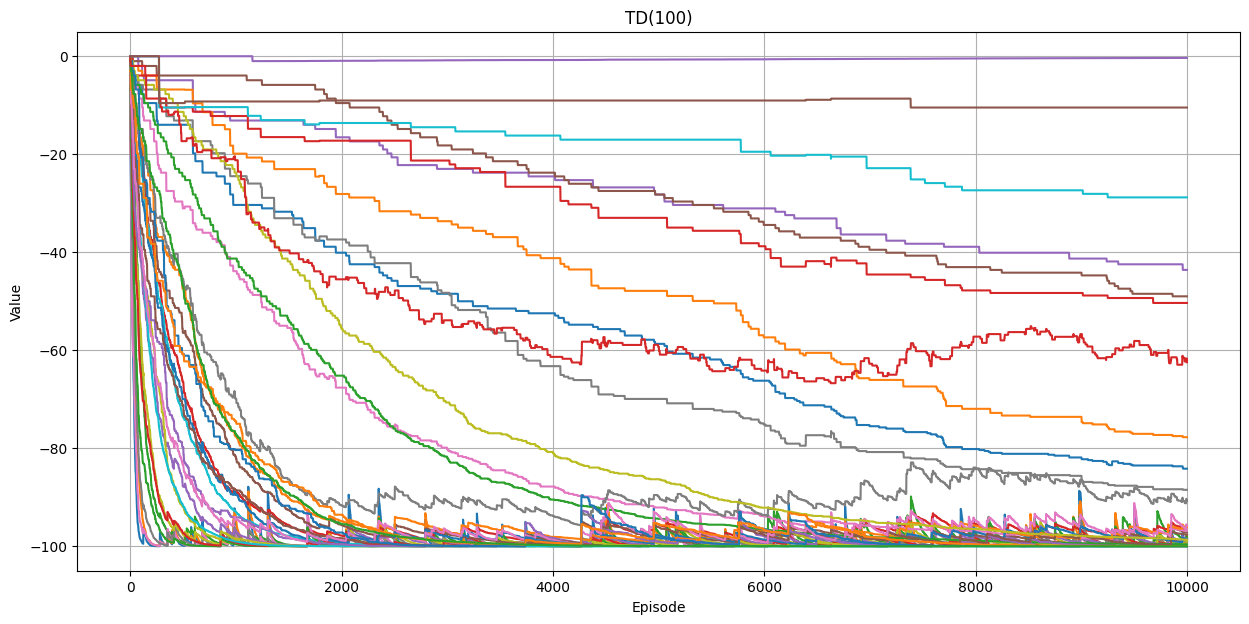

In [34]:
plt.figure(figsize=(15,7))
plt.plot(tdn100_state_vals)
plt.xlabel('Episode')
plt.ylabel('Value')
plt.title('TD(100)')
plt.grid()

<!-- END QUESTION -->

## Question 2.4 - Unifying (14 pts)

The intuition is that *n-step* `TD` should generalize both *Monte Carlo prediction* and `TD(0)`. We saw in the previous question that it does not seem to be equivalent to MC prediction. Modify your *n-step* `TD` algorithm such that when $n=100$, it becomes equivalent to *Every visit Monte Carlo prediction*. Hint: This has to do with the step size $\alpha$.

<!-- BEGIN QUESTION -->

### Question 2.4a (3 pts)
Before implementing this modified `TDN`, identify what the new formula for $\alpha$ should be.

First visit Monte Carlo: $V(S_t) = V(S_t) + \alpha ( R_{t+1} + \gamma R_{t+2} + ... + \gamma^{n} R_{t+n} - V(S_t))$

Every visit Monte Carlo: $V(S_t) = V(S_t) + \mathbb{E} [ R_{t+1} + \gamma R_{t+2} + ... + \gamma^{n} R_{t+n} - V(S_t)]$

TD(0): $V(S_t) = V(S_t) + \alpha  ( R_{t+1} + \gamma V(S_{t+1}) - V(S_t))$

TD(n): $V(S_t) = V(S_t) + \alpha  ( R_{t+1} + \gamma R_{t+2} + ... + \gamma^n V(S_{t+n}) - V(S_t))$

Let's define $m$ to be the number of time the state $S_t$ has been visited so far.

To make TD(n) act like Every visit Monte Carlo, we need to make set $n = \infty$ and set $\alpha = \frac{1}{m}$

Thus: $V(S_t) = V(S_t) + \frac{1}{m} * (R_{t+1} + \gamma R_{t+2} + ... + \gamma^n V(S_{t+n}) - V(S_t))$



<!-- END QUESTION -->

### Question 2.4b (5 pts)
Now implement the `modified_tdn` method that uses this new step size. Most of this method is the same as `tdn`.

In [49]:
def modified_tdn(policy, env, n, num_episodes=100, discount=0.99):
    """
    This function should largely be equivalent to the tdn function implemented in Question 3.
    The only difference is the step size will be dynamically changed using your formula in Q5a).
    You may copy paste most lines in the previous implementation.

    Input:
        policy (int -> int): policy to evaluate
        env (DiscreteEnv): FloorIsLava environment
        n (int): Number of steps before bootstrapping for td(n) algorithm
        step_size (float): step size alpha of td learning
        num_episodes (int): number of episodes to run the algorithm for
        discount (float): discount factor
    Returns state_values_trace (list of lists):
        Value estimates of each state at every episode of training.

    Do not modify state_values_trace. JUST UPDATE state_values and state_visitation.
        state_values keep tracks of the value of each state. Each index of state_values represents one state.
    """
    state_values = [0 for i in range(env.observation_space.n)]
    state_visitation = [0 for i in range(env.observation_space.n)]
    state_values_trace = []
    for j in (range(num_episodes)):
        # TO IMPLEMENT
        # --------------------------------
        obs, info = env.reset()
        T = float('inf')
        t = 0
        episode_rewards = []
        episode_states = [obs]
        episode_actions = []
        while True:
            if t < T:
                action = policy(obs)
                obs, reward, _, done, info = env.step(action)
                episode_actions.append(action)
                episode_states.append(obs)
                episode_rewards.append(reward)
                if done:
                    T = t + 1
            tau = t - n
            if tau >= 0:
                G = sum(discount**(i-tau) * episode_rewards[i] for i in range(tau, min(tau+n+1, T)))
                if tau + n+1 < T:
                    G = G + discount**(n+1) * state_values[episode_states[tau+n+1]]
                tau_state = episode_states[tau]
                state_visitation[tau_state] = state_visitation[tau_state] + 1
                state_values[tau_state] = state_values[tau_state] + 1/state_visitation[tau_state] * (G - state_values[tau_state])
            if tau == T - 1:
                break
            t = t + 1
        # --------------------------------
        state_values_trace.append([s for s in state_values])
    return state_values_trace

In [50]:
grader.check("question 2.4b")

question 2.4b results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 2.4c - Plotting (3 pts)
Now plot the same plot as in the previous questions with $n=100$, and compare it with the *Every Visit MC prediction* algorithm. You should now see that their behaviors match.

In [51]:
env = FloorIsLava(map_name="6x6", slip_rate=0.1)
# Set seed
seed = 10
env.seed(seed)
np.random.seed(seed)
random.seed(seed)
mod_tdn100_state_vals = modified_tdn(random_policy, env, n=100, num_episodes=10000)

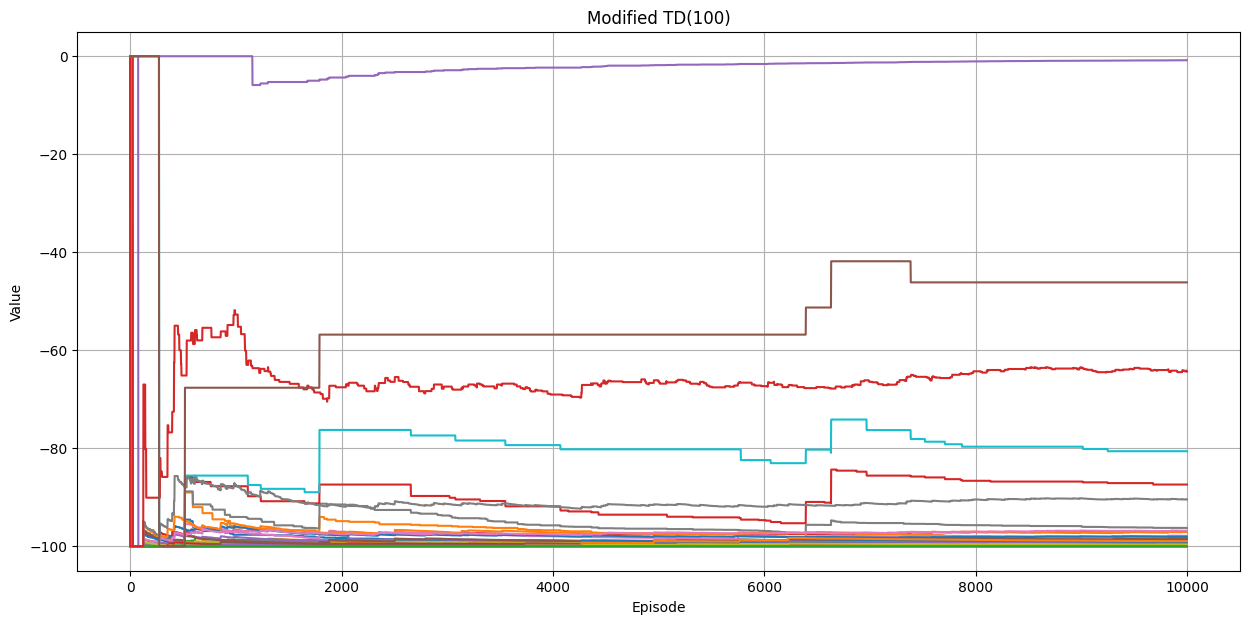

In [52]:
plt.figure(figsize=(15,7))
plt.plot(mod_tdn100_state_vals)
plt.xlabel('Episode')
plt.ylabel('Value')
plt.title('Modified TD(100)')
plt.grid()

### Question 2.4d  (3 pts)
Compare this new figure to `TD(0)` and *Every visit Monte Carlo Prediction*. Do you notice that it closely resembles the latter?

Type your answer here

<!-- END QUESTION -->

# Part 3 - Temporal Difference Control Methods (30 pts)

Continuing with the same `FloorIsLava` environment as before with 0 `slip_rate` this time, we will investigate various TD-control methods in this section. In this question you need to implement a training procedure similar to the `generate_episode` function in Part 0, but instead of running a fixed policy, you need to ensure that the agent is trained (i.e., value estimate is updated) throughout the learning phase.

First, carefully read and understand the code provided for a base class that will serve as the parent class for all learning agents you will implement in this section.

In [120]:
class Agent():
    def __init__(self):
        pass

    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.

        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }

        """
        np.random.seed(agent_init_info['seed'])
        random.seed(agent_init_info['seed'])
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]

        # Create an array for action-value estimates and initialize it to zero.
        self.q = np.zeros((self.num_states, self.num_actions))

    def get_current_policy(self):
        """
        Returns the epsilon greedy policy of the agent following the previous implementation of
        make_eps_greedy_policy

        Returns:
            Policy (callable): fun(state) -> action
        """
        return make_eps_greedy_policy(self.q, epsilon=self.epsilon)

    def agent_step(self, prev_state, prev_action, prev_reward, current_state, done):
        """ A learning step for the agent given a state, action, reward, next state and done
        Args:
            prev_state (int): the state observation from the enviromnents last step
            prev_action (int): the action taken given prev_state
            prev_reward (float): The reward received for taking prev_action in prev_state
            current_state (int): The state received for taking prev_action in prev_state
            done (bool): Indicator that the episode is done
        Returns:
            action (int): the action the agent is taking given current_state
        """
        raise NotImplementedError


## Question 3.1 - Helper methods (3 pts)

Implement the method `train_episode`, that is similar in function to the `generate_episode`, except it takes an agent as an argument instead of the policy, and simultaneously trains the agent while generating an episode. (Hint, make use of the `agent_step` method of the `Agent` class to both get an action and train the agent.)

In [98]:
def train_episode(agent, env):
    """
    Input:
        agent (Agent): an agent of the class Agent implemented above
        env (DiscreteEnv): The FloorIsLava environment
    Returns:
        states (list): the sequence of states in the generated episode
        actions (list): the sequence of actions in the generated episode
        rewards (list): the sequence of rewards in the generated episode
    """
    states = []
    rewards = []
    actions = []
    done = False
    current_state, _ = env.reset()
    action = agent.get_current_policy()(current_state)
    actions.append(action)
    states.append(current_state)
    while not done:
        # TO IMPLEMENT
        # --------------------------
        new_state, reward, _, done, _ = env.step(action)
        action = agent.agent_step(current_state, action, reward, new_state, done)
        actions.append(action)
        states.append(new_state)
        rewards.append(reward)
        current_state = new_state
        # --------------------------
    return states, actions, rewards

In [71]:
grader.check("question 3.1")

question 3.1 results: All test cases passed!

We then provide the code to train an agent using this newly written method.

In [72]:
def td_control(agent_class, epsilon, step_size, run, num_episodes=100, discount=0.99):
    agent_info = {
        "num_actions": 4,
        "num_states": 36,
        "epsilon": epsilon,
        "step_size": step_size,
        "discount": discount,
        "seed": run
        }
    agent = agent_class()
    agent.agent_init(agent_info)

    env = FloorIsLava(map_name="6x6", slip_rate=0.)
    # Set seed
    seed = run
    env.seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    all_returns = []

    for j in (range(num_episodes)):
        states, actions, rewards = train_episode(agent, env)
        all_returns.append(np.sum(rewards))

    return all_returns, agent

## Question 3.2 - SARSA (8 pts)



### Question 3.2a (5 pts)
Implement the SARSA control algorithm. Recall the update rule given $s, a, r, s', a'$:

$$Q(s,a) \leftarrow Q(s, a) + \alpha \left[ r+ \gamma Q(s', a') - Q(s,a) \right]$$

And make sure to handle terminal states correctly.

In [121]:
class SarsaAgent(Agent):

    def agent_step(self, prev_state, prev_action, prev_reward, current_state, done):
        """ A learning step for the agent given SARS
        Args:
            prev_state (int): the state observation from the environments last step
            prev_action (int): the action taken given prev_state
            prev_reward (float): The reward received for taking prev_action in prev_state
            current_state (int): The state received for taking prev_action in prev_state
            done (bool): Indicator that the episode is done
        Returns:
            action (int): the action the agent is taking given current_state
        """
        # TO IMPLEMENT
        # --------------------------
        q_s_a = self.q[prev_state, prev_action]
        action = self.get_current_policy()(current_state)
        if done:
            self.q[prev_state, prev_action] = q_s_a + self.step_size * (prev_reward - q_s_a)
        else:
            self.q[prev_state, prev_action] = q_s_a + self.step_size * (prev_reward + self.discount * self.q[current_state, action] - q_s_a)
        # --------------------------
        return action


In [144]:
grader.check("question 3.2a")

question 3.2a results:
    question 3.2a - 1 result:
        ❌ Test case failed
        Error at line 13 in test question 3.2a:
              np.testing.assert_allclose(answer, returns)
        AssertionError: 
        Not equal to tolerance rtol=1e-07, atol=0

        Mismatched elements: 10 / 10 (100%)
        Max absolute difference: 27
        Max relative difference: 0.20300752
         x: array([-119, -122, -115, -118, -121, -125, -106, -116, -117, -110])
         y: array([-117, -106, -104, -121, -113, -116, -133, -104, -110, -117])

<!-- BEGIN QUESTION -->

### Question 3.2b - Evaluating (3 pts)

Let's run the SARSA algorithm on our 0 slip rate environment. We set $\epsilon=0.5$, $\alpha=0.1$, $\gamma=0.99$, and run the algorithm 5 times over 10000 episodes.

In [102]:
## Running SARSA on the environment on 5 different seeds

epsilon = 0.5 #@param {allow-input: true}
step_size = 0.1 #@param {allow-input: true}
discount = 0.99 #@param
num_runs =  5 #@param {allow-input: true}
num_episodes = 10000 #@param {allow-input: true}

sarsa_returns = []
sarsa_agents = []
for t in range(num_runs):
    returns, agent = td_control(agent_class=SarsaAgent, epsilon=epsilon, step_size=step_size, run=t, num_episodes=num_episodes, discount=discount)
    sarsa_returns.append(returns)
    sarsa_agents.append(agent)

Now let's evaluate our agents with 0 exploration.

In [103]:
## Evaluating the agent with 0 exploration, i.e epsilon=0

sarsa_optimal_returns = []
for t in range(num_runs):
    env = FloorIsLava(map_name="6x6", slip_rate=0.)
    optimal_policy = make_eps_greedy_policy(sarsa_agents[t].q, epsilon=0.)
    s, a, r = generate_episode(optimal_policy, env, render=False)
    print('Optimal return for seed {0} is {1}'.format(t, np.sum(r)))
    sarsa_optimal_returns.append(np.sum(r))

Optimal return for seed 0 is -7
Optimal return for seed 1 is -7
Optimal return for seed 2 is -7
Optimal return for seed 3 is -7
Optimal return for seed 4 is -7


<!-- END QUESTION -->

## Question 3.3 - Q-learning (8 pts)


### Question 3.3a (5 pts)
Implement the Q-learning control algorithm. Recall the update rule:
$$Q(s,a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s,a) \right]$$

And make sure to handle terminal states correctly

In [104]:
#@title Q-learning

class QLearningAgent(Agent):

    def agent_step(self, prev_state, prev_action, prev_reward, current_state, done):
        """ A learning step for the agent given SARS
        Args:
            prev_state (int): the state observation from the environments last step
            prev_action (int): the action taken given prev_state
            prev_reward (float): The reward received for taking prev_action in prev_state
            current_state (int): The state received for taking prev_action in prev_state
            done (bool): Indicator that the episode is done
        Returns:
            action (int): the action the agent is taking given current_state
        """
        # TO IMPLEMENT
        # --------------------------
        q_s_a = self.q[prev_state, prev_action]
        action = self.get_current_policy()(current_state)
        if done:
            self.q[prev_state, prev_action] = q_s_a + self.step_size * (prev_reward - q_s_a)
        else:
            self.q[prev_state, prev_action] = q_s_a + self.step_size * (prev_reward + self.discount * np.max(self.q[current_state]) - q_s_a)
        # --------------------------
        return action

In [105]:
grader.check("question 3.3a")

question 3.3a results:
    question 3.3a - 1 result:
        ❌ Test case failed
        Error at line 13 in test question 3.3a:
              np.testing.assert_allclose(answer, returns)
        AssertionError: 
        Not equal to tolerance rtol=1e-07, atol=0

        Mismatched elements: 10 / 10 (100%)
        Max absolute difference: 27
        Max relative difference: 0.20300752
         x: array([-119, -122, -115, -118, -121, -125, -106, -116, -117, -110])
         y: array([-117, -106, -104, -121, -113, -116, -133, -104, -110, -117])

<!-- BEGIN QUESTION -->

### Question 3.3b -  Evaluating (3 pts)

Let's run the Q-learning algorithm on our 0 slip rate environment. We set $\epsilon=0.5$, $\alpha=0.1$, $\gamma=0.99$, and run the algorithm 5 times over 10000 episodes.

In [106]:
## Running Q-learning on the environment on 5 different seeds

epsilon = 0.5 #@param {allow-input: true}
step_size = 0.1 #@param {allow-input: true}
discount = 0.99 #@param
num_runs =  5 #@param {allow-input: true}
num_episodes = 10000 #@param {allow-input: true}

q_returns = []
q_agents = []
for t in range(num_runs):
    returns, agent = td_control(agent_class=QLearningAgent, epsilon=epsilon, step_size=step_size, run=t, num_episodes=num_episodes, discount=discount)
    q_returns.append(returns)
    q_agents.append(agent)

Again, we evaluate the agent with 0 exploration

In [107]:
## Evaluating the agent with 0 exploration, i.e epsilon=0

q_optimal_returns = []
for t in range(num_runs):
    env = FloorIsLava(map_name="6x6", slip_rate=0.)
    optimal_policy = make_eps_greedy_policy(q_agents[t].q, epsilon=0.)
    s, a, r = generate_episode(optimal_policy, env, render=False)
    print('Optimal return for seed {0} is {1}'.format(t, np.sum(r)))
    q_optimal_returns.append(np.sum(r))

Optimal return for seed 0 is -7
Optimal return for seed 1 is -7
Optimal return for seed 2 is -7
Optimal return for seed 3 is -7
Optimal return for seed 4 is -7


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Question 3.4 - Plotting everything (5 pts)

###### Now let us plot the learning curves of our algorithms, and their final optimal returns given a deterministic policy.

Text(0.5, 1.0, 'SARSA vs Q-Learning')

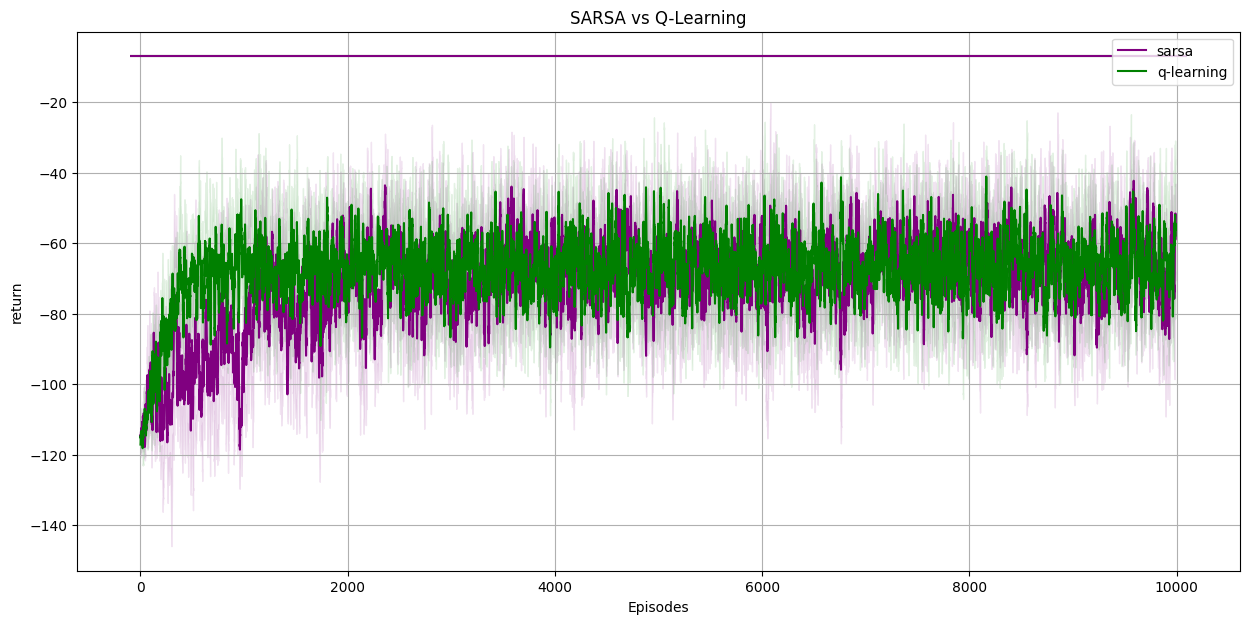

In [108]:
def moving_avg(stuff, window):
    return np.convolve(stuff, np.ones(window)/window, mode='valid')

plt.figure(figsize=(15,7))
plot_many([moving_avg(r, 10) for r in sarsa_returns], label='sarsa', color='purple')
plot_many([moving_avg(r, 10) for r in q_returns], label='q-learning', color='green')
# plot_many([moving_avg(r, 10) for r in esarsa_returns], label='expected_sarsa', color='orange')
plt.hlines([np.mean(q_optimal_returns)], -100, 10100, color='green')
plt.hlines([np.mean(sarsa_optimal_returns)], -100, 10100, color='purple')
# plt.hlines([np.mean(esarsa_optimal_returns)], -100, 10100, color='orange')
plt.legend()
plt.grid()
plt.xlabel('Episodes')
plt.ylabel('return')
plt.title('SARSA vs Q-Learning')

<!-- END QUESTION -->

## Question 3.5 - Analysis (6 pts)


### Question 3.5a (3 pts)
Out of the two algorithms, which one prefers safer and more conservative (or cautious) policies in the learning phase? Which prefers aggressive policies?

Type your answer here

### Quesiton 3.5b (3 pts)
Despite the learning curve of *Q-learning* being similar to that of SARSA, why does it seem to have a better
 return during evaluation?

Type your answer here

# Part 4 -- Deep Q-learning (20 points)

## Question 4.1 - DQN
In the previous sections, you've been storing Q-values for each state in a lookup table.
This becomes quite difficult when learning in environments with large or even infinite
state spaces. To address this problem, we'll study Deep Q-Learning (DQN), an algorithm
that combines some of the principles you've learned earlier in the assignment with
function approximation from neural networks.

### Question 4.1a (15 points)
Implement the `get_action` and `compute_targets` for the `DQNAgent` class below.

For `get_action`, you need to write an epsilon greedy policy that selects a random
action with probablity epsilon, and selects the action with the highest Q-value
according to the agent with probability (1-epsilon).

For `compute_targets`, you need to compute the 1-step targets for all the transitions
given using the agent's target network. The target should be computed as:
$$max_{a'\in A} r + \gamma Q_{target}(s', a')$$
if $s'$ is not a terminal state, and $r$ if it is a terminal state.


In [ ]:
class ReplayBuffer:
    """This class implements a replay buffer for experience replay. You do not need to
    implement anything here."""
    def __init__(self, buffer_size, observation_space, action_space):
        self.buffer_size = buffer_size
        self.observations = np.zeros(
            (buffer_size,) + observation_space.shape, dtype=observation_space.dtype
        )
        self.next_observations = np.zeros(
            (buffer_size,) + observation_space.shape, dtype=observation_space.dtype
        )
        self.actions = np.zeros(
            (buffer_size,) + action_space.shape, dtype=action_space.dtype
        )
        self.rewards = np.zeros((buffer_size,), dtype=np.float32)
        self.terminated = np.zeros((buffer_size,), dtype=np.uint8)
        self.position = 0
        self.num_added = 0

    def add(self, observation, action, reward, next_observation, terminated):
        """
        Adds a new experience tuple to the replay buffer.

        Parameters:
            - observation (np.ndarray): The current observation.
            - action (int): The action taken.
            - reward (float): The reward received.
            - next_observation (np.ndarray): The next observation.
            - terminated (bool): Whether the episode terminated after this experience.

        Returns:
            - None
        """
        self.observations[self.position] = observation
        self.next_observations[self.position] = next_observation
        self.actions[self.position] = action
        self.rewards[self.position] = reward
        self.terminated[self.position] = terminated
        self.position = (self.position + 1) % self.buffer_size
        self.num_added += 1

    def sample(self, batch_size):
        """
        Samples a batch of experiences from the replay buffer.

        Parameters:
            - batch_size (int): The number of experiences to sample.

        Returns:
            - observations (np.ndarray): The current observations. Shape (batch_size,
              observation_dim)
            - actions (np.ndarray): The actions taken. Shape (batch_size, action_dim)
            - rewards (np.ndarray): The rewards received. Shape (batch_size,)
            - next_observations (np.ndarray): The next observations. Shape (batch_size,
              observation_dim)
            - terminated (np.ndarray): Whether the episode terminated after this
              experience.
        """
        buffer_size = min(self.num_added, self.buffer_size)
        indices = np.random.randint(0, buffer_size, size=batch_size)
        return (
            self.observations[indices],
            self.actions[indices],
            self.rewards[indices],
            self.next_observations[indices],
            self.terminated[indices],
        )



In [ ]:
class DQNAgent:
    def __init__(
        self,
        observation_space,
        action_space,
        epsilon,
        learning_starts_at,
        learning_frequency,
        learning_rate,
        discount_factor,
        buffer_size,
        target_update_frequency,
        batch_size,
    ):
        self.observation_space = observation_space
        self.action_space = action_space
        self.network = self.build_network(observation_space, action_space)
        self.target_network = copy.deepcopy(self.network).requires_grad_(False)

        self.replay_buffer = ReplayBuffer(
            buffer_size=buffer_size,
            observation_space=observation_space,
            action_space=action_space,
        )
        self.epsilon = epsilon
        self.learning_starts_at = learning_starts_at
        self.learning_frequency = learning_frequency
        self.discount_factor = discount_factor
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=learning_rate)
        self.loss_fn = torch.nn.MSELoss()
        self.target_update_frequency = target_update_frequency
        self.batch_size = batch_size

    def build_network(self, observation_space, action_space):
        """
        Builds a neural network that maps observations to Q-values for each action.
        """
        input_dimension = observation_space.shape[0]
        output_dimension = action_space.n
        return torch.nn.Sequential(
            torch.nn.Linear(input_dimension, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, output_dimension),
        )

    def get_action(self, state):
        """Implements epsilon greedy policy. With probability epsilon, take a random
        action. Otherwise, take the action that has the highest Q-value for the
        current state. For sampling a random action from the action space, take a look
        at the API for spaces: https://gymnasium.farama.org/api/spaces/#the-base-class.
        Do not hardcode the number of actions you are sampling from.

        Parameters:
            - state (np.ndarray): The current state.

        Returns:
            - action (int): The action to take.
        """
        # TO IMPLEMENT
        # --------------------------
        ...
        # --------------------------

    def update(self, experience, step):
        """
        Adds the experience to the replay buffer and performs a training step.

        Parameters:
            - experience (dict): A dictionary containing the keys "observation",
              "action", "reward", "next_observation", "terminated", and "truncated".
        """
        self.replay_buffer.add(
            experience["observation"],
            experience["action"],
            experience["reward"],
            experience["next_observation"],
            experience["terminated"],
        )
        metrics = {}
        if step > self.learning_starts_at and step % self.learning_frequency == 0:
            metrics = self.perform_training_step()


        if step % self.target_update_frequency == 0:
            self.target_network.load_state_dict(self.network.state_dict())
        return metrics

    def perform_training_step(self):
        (
            observations,
            actions,
            rewards,
            next_observations,
            terminated,
        ) = self.replay_buffer.sample(self.batch_size)
        observations = torch.Tensor(observations)
        actions = torch.Tensor(actions).long()
        rewards = torch.Tensor(rewards)
        next_observations = torch.Tensor(next_observations)
        terminated = torch.Tensor(terminated)
        q_values = self.network(observations).gather(1, actions.unsqueeze(1)).squeeze()
        with torch.no_grad():
            targets = self.compute_targets(rewards, next_observations, terminated)
        loss = self.loss_fn(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return {
            "loss": loss.item(),
            "q_values": q_values.mean().detach().numpy()
        }

    def compute_targets(self, rewards, next_observations, terminated):
        """
        Computes the target Q-values for a batch of transitions. Make sure to use the
        target network for this computation. If the episode terminated, the target
        Q-value should be the reward, otherwise the reward plus the discounted
        maximum target Q-value for the next state.

        In order to do this efficiently, you should not use a for loop or any if
        statements, but instead use tensor operations and the fact that (1 - terminated)
        will be 0 for all the terminal transitions.

        Parameters:
            - rewards (torch.Tensor): The rewards received for each transition in the
                batch. Shape (batch_size,)
            - next_observations (torch.Tensor): The next observations for each
                transition in the batch. Shape (batch_size, observation_dim)
            - terminated (torch.Tensor): Whether the episode terminated after each
                transition in the batch. Shape (batch_size,)
        Returns:
            - targets (torch.Tensor): The targets for each transition in the batch.
                Shape (batch_size,)
        """
        # TO IMPLEMENT
        # --------------------------
        ...
        # --------------------------


In [ ]:
grader.check("question 4.1a")

<!-- BEGIN QUESTION -->

### Question 4.1b (5 points) - Evaluating and Plotting
Run your DQN agent below on the classic
[Cartpole](https://gymnasium.farama.org/environments/classic_control/cart_pole/)
environment. The goal in this environment is to balance a pole on top of a cart. The
input space is a 4-dimensional state representing the position and velocity of the cart
and the pole angle. Since this is a continuous environment, we cannot do simple tabular
Q-learning, and need to use function approximation (in this case with neural networks).
Your agent should be able to get the maximum return (500) over the course of training.
It is ok if it periodically diverges. Run the agent, and generate the plots in the next
cell. Include these plots in your PDF report.

In [ ]:
env = gym.make("CartPole-v1")
agent = DQNAgent(
    observation_space=env.observation_space,
    action_space=env.action_space,
    epsilon=.1,
    learning_starts_at=500,
    learning_frequency=10,
    learning_rate=.001,
    discount_factor=0.99,
    buffer_size=1000,
    target_update_frequency=100,
    batch_size=128,
)

NUM_STEPS = 100000
LOG_FREQUENCY = 2000
episode_rewards = []
losses = []
q_vals = []
episode_reward = 0
state, _ = env.reset()
for step in range(NUM_STEPS):
    action = agent.get_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    episode_reward += reward
    metrics = agent.update(
        {
            "observation": state,
            "action": action,
            "reward": reward,
            "next_observation": next_state,
            "terminated": terminated,
            "truncated": truncated,
        },
        step,
    )
    state = next_state
    if terminated or truncated:
        episode_rewards.append(episode_reward)
        episode_reward = 0
        episode_length = 0
        state, _ = env.reset()
    if step % LOG_FREQUENCY == 0:
        if 'loss' in metrics:
            losses.append(metrics["loss"])
            q_vals.append(metrics["q_values"])

        print(
            "Step: {0}, Average Return: {1:.2f}".format(
                step, np.mean(episode_rewards[-10:]))
            )


In [ ]:
def smooth(array, n_running_average=10):
    return np.convolve(np.array(array), np.ones(n_running_average)/n_running_average, mode="full")[:-(n_running_average-1)]
plt.figure(figsize=(6, 9))
plt.subplot(3, 1, 1)
plt.plot(smooth(episode_rewards))
plt.ylabel("Episode Returns")
plt.xlabel("Episode")
plt.subplot(3, 1, 2)
plt.plot((np.arange(len(losses)) + 1) * LOG_FREQUENCY, smooth(losses))
plt.ylabel("Loss")
plt.xlabel("Steps")
plt.subplot(3, 1, 3)
plt.plot((np.arange(len(q_vals)) + 1) * LOG_FREQUENCY, smooth(q_vals))
plt.ylabel("Q-Values")
plt.xlabel("Steps")
plt.show()


<!-- END QUESTION -->

